# Image classification with Vision Transformer and Pytorch

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

## Setup

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Prepare the data

In [23]:
# Define CIFAR-100 dataset details
num_classes = 100
input_shape = (32, 32, 3)

# Transformations for CIFAR-100 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

# Check dataset shapes
x_train_shape = (len(train_dataset),) + input_shape
y_train_shape = (len(train_dataset),)
x_test_shape = (len(test_dataset),) + input_shape
y_test_shape = (len(test_dataset),)

print(f"x_train shape: {x_train_shape} - y_train shape: {y_train_shape}")
print(f"x_test shape: {x_test_shape} - y_test shape: {y_test_shape}")

Files already downloaded and verified
Files already downloaded and verified
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000,)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000,)


## Configure the hyperparameters

In [24]:
# Hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is for testing
image_size = 72  # Resize input images to this size
input_dim = 3  # RGB images
patch_size = 6  # Size of patches extracted from input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,  # First transformer layer size
    projection_dim,      # Second transformer layer size
]
transformer_layers = 8  # Number of transformer layers
mlp_head_units = [
    2048,  # First dense layer in the classifier head
    1024,  # Second dense layer in the classifier head
]

# Print hyperparameters
print(f"Learning Rate: {learning_rate}")
print(f"Weight Decay: {weight_decay}")
print(f"Batch Size: {batch_size}")
print(f"Num Epochs: {num_epochs}")
print(f"Image Size: {image_size}")
print(f"Input Dim: {input_dim}")
print(f"Patch Size: {patch_size}")
print(f"Num Patches: {num_patches}")
print(f"Projection Dim: {projection_dim}")
print(f"Num Heads: {num_heads}")
print(f"Transformer Units: {transformer_units}")
print(f"Transformer Layers: {transformer_layers}")
print(f"MLP Head Units: {mlp_head_units}")

Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 256
Num Epochs: 10
Image Size: 72
Input Dim: 3
Patch Size: 6
Num Patches: 144
Projection Dim: 64
Num Heads: 4
Transformer Units: [128, 64]
Transformer Layers: 8
MLP Head Units: [2048, 1024]


## Use data augmentation

In [32]:
# Compute mean and standard deviation for normalization
def compute_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=5000, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    total_samples = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_samples
    mean /= total_samples
    std /= total_samples
    return mean, std

train_mean, train_std = compute_mean_std(train_dataset)
test_mean, test_std = compute_mean_std(test_dataset)

# Data augmentation pipeline
train_data_augmentation = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resizing to 72x72
    transforms.RandomHorizontalFlip(),           # Random horizontal flip
    transforms.RandomRotation(0.02 * 360),               # Random rotation by ±0.02 * 360 degrees
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  # Random zoom
    transforms.ToTensor(),                       # Convert to PyTorch tensor
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())  # Normalize using computed mean & std
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resizing to 72x72
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean.tolist(), std=test_std.tolist())
])

# Updated training dataset with augmentation
train_dataset_augmentation = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_data_augmentation)
test_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


## Implement multilayer perceptron (MLP)

In [33]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, dropout_rate):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for units in hidden_units:
            self.layers.append(nn.Linear(input_dim, units))  # Set in_features explicitly
            self.layers.append(nn.GELU())
            self.layers.append(nn.Dropout(dropout_rate))
            input_dim = units  # Update input_dim for the next layer

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## Implement patch creation as a layer

In [34]:
class Patches(nn.Module):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def forward(self, images):
        # Get input dimensions
        batch_size, channels, height, width = images.size()
        assert height % self.patch_size == 0 and width % self.patch_size == 0, \
            "Image dimensions must be divisible by the patch size. {}".format(images.size())

        # Number of patches
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        # Rearrange input tensor into patches
        patches = images.unfold(2, self.patch_size, self.patch_size)  # Unfold height
        patches = patches.unfold(3, self.patch_size, self.patch_size)  # Unfold width
        patches = patches.contiguous().view(
            batch_size, channels, -1, self.patch_size, self.patch_size
        )
        patches = patches.permute(0, 2, 3, 4, 1)  # Rearrange to (batch, patches, h, w, c)
        patches = patches.contiguous().view(
            batch_size, num_patches_h * num_patches_w, -1
        )  # Flatten patches to (batch, num_patches, patch_size * patch_size * channels)

        return patches

    def extra_repr(self):
        return f"patch_size={self.patch_size}"

Let's display patches for a sample image

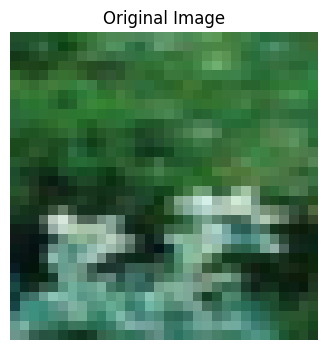

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


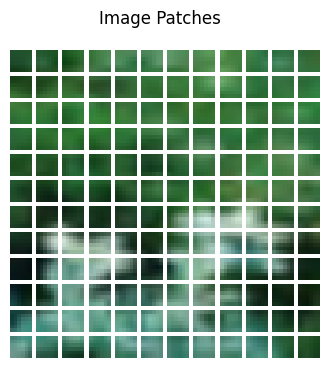

In [35]:
# Randomly select an image from the CIFAR-100 training dataset
image, _ = train_dataset[np.random.choice(len(train_dataset))]
image_np = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow((image_np * 0.5 + 0.5))  # Denormalize and convert to uint8
plt.axis("off")
plt.title("Original Image")
plt.show()

# Resize the image to the specified size
resize_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert Tensor to PIL Image
    transforms.Resize((image_size, image_size)),  # Resize to (72, 72)
    transforms.ToTensor(),  # Convert back to Tensor
])
resized_image = resize_transform((image_np * 0.5 + 0.5)).unsqueeze(0)  # Add batch dimension

# Create patches
patch_layer = Patches(patch_size=patch_size)
patches = patch_layer(resized_image)

# Display information about the patches
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.size(1)}")
print(f"Elements per patch: {patches.size(-1)}")

# Visualize patches
n = int(np.sqrt(patches.size(1)))  # Number of patches along one dimension
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patch.view(patch_size, patch_size, 3)  # Reshape and permute back to (H, W, C)
    plt.imshow((patch_img.detach().numpy() * 255).astype("uint8"))
    plt.axis("off")
plt.suptitle("Image Patches")
plt.show()

## Implement the patch encoding layer

The `PatchEncoder` module will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [36]:
class PatchEncoder(nn.Module):
    def __init__(self, num_patches, projection_dim, patch_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = nn.Linear(in_features=patch_dim, out_features=projection_dim)
        self.position_embedding = nn.Embedding(num_patches, projection_dim)

    def forward(self, patches):
        # Generate position indices
        positions = torch.arange(0, self.num_patches, device=patches.device).unsqueeze(0)
        # Project patches and add position embeddings
        projected_patches = self.projection(patches)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `nn.MultiheadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.

In [37]:
class VisionTransformer(nn.Module):
    def __init__(self, input_dim, patch_size, num_patches, projection_dim, transformer_layers, num_heads, transformer_units, mlp_head_units, num_classes, dropout_rate=0.1):
        super(VisionTransformer, self).__init__()

        # Patch creation and encoding
        self.patch_layer = Patches(patch_size)
        self.patch_encoder = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim, patch_dim=patch_size * patch_size * input_dim)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            nn.ModuleDict({
                "layernorm1": nn.LayerNorm(projection_dim, eps=1e-6),
                "mha": nn.MultiheadAttention(embed_dim=projection_dim, num_heads=num_heads, dropout=dropout_rate),
                "layernorm2": nn.LayerNorm(projection_dim, eps=1e-6),
                "mlp": MLP(input_dim=projection_dim, hidden_units=transformer_units, dropout_rate=dropout_rate)
            })
            for _ in range(transformer_layers)
        ])

        # Classifier head
        self.layernorm = nn.LayerNorm(projection_dim, eps=1e-6)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.mlp_head = MLP(input_dim=num_patches * projection_dim, hidden_units=mlp_head_units, dropout_rate=0.5)
        self.classifier = nn.Linear(mlp_head_units[-1], num_classes)

    def forward(self, x):
      # Create patches
      patches = self.patch_layer(x)

      # Encode patches
      encoded_patches = self.patch_encoder(patches)

      # Transformer layers
      for block in self.transformer_blocks:
          x1 = block["layernorm1"](encoded_patches)
          attention_output, _ = block["mha"](x1, x1, x1)
          x2 = attention_output + encoded_patches  # Skip connection 1
          x3 = block["layernorm2"](x2)
          mlp_output = block["mlp"](x3)
          encoded_patches = mlp_output + x2  # Skip connection 2

      # Representation
      representation = self.layernorm(encoded_patches)
      representation = self.flatten(representation)
      representation = self.dropout(representation)

      # MLP head
      features = self.mlp_head(representation)

      # Classifier
      logits = self.classifier(features)
      return logits

## Compile, train, and evaluate the mode

Epoch 1/10, Train Loss: 4.5926, Train Acc: 0.0143, Val Loss: 4.3825, Val Acc: 0.0438
Epoch 2/10, Train Loss: 4.2336, Train Acc: 0.0519, Val Loss: 4.0030, Val Acc: 0.0858
Epoch 3/10, Train Loss: 4.0087, Train Acc: 0.0740, Val Loss: 3.8454, Val Acc: 0.1062
Epoch 4/10, Train Loss: 3.8929, Train Acc: 0.0899, Val Loss: 3.7571, Val Acc: 0.1260
Epoch 5/10, Train Loss: 3.7900, Train Acc: 0.1083, Val Loss: 3.6165, Val Acc: 0.1466
Epoch 6/10, Train Loss: 3.6713, Train Acc: 0.1302, Val Loss: 3.4450, Val Acc: 0.1802
Epoch 7/10, Train Loss: 3.5382, Train Acc: 0.1519, Val Loss: 3.3420, Val Acc: 0.1908
Epoch 8/10, Train Loss: 3.4122, Train Acc: 0.1742, Val Loss: 3.2619, Val Acc: 0.2074
Epoch 9/10, Train Loss: 3.3105, Train Acc: 0.1937, Val Loss: 3.1687, Val Acc: 0.2184
Epoch 10/10, Train Loss: 3.2300, Train Acc: 0.2072, Val Loss: 3.0752, Val Acc: 0.2466


<ipython-input-38-51d1cabb07d2>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 3.0277, Test Accuracy: 0.2558, Test Top-5 Accuracy: 0.5494


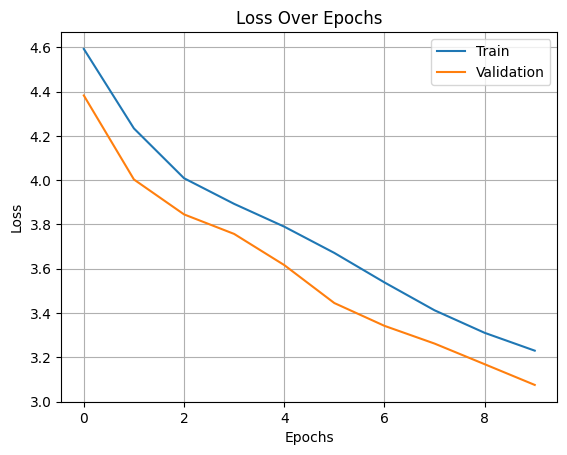

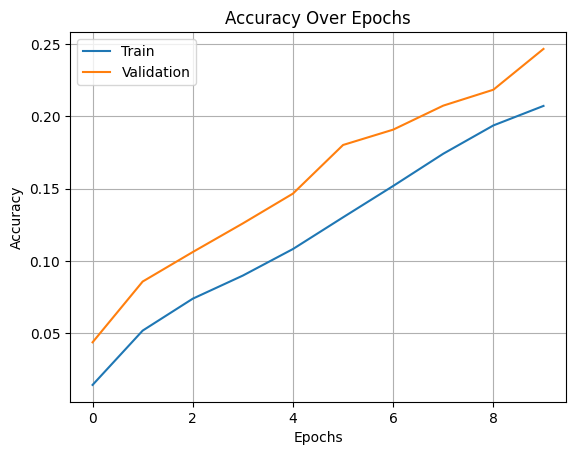

In [38]:
def run_experiment(model, train_dataset, test_dataset, batch_size, num_epochs, learning_rate, weight_decay, device):
    # Split training dataset into train and validation sets
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Move model to device (GPU/CPU)
    model = model.to(device)

    # Optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Track metrics
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    best_val_acc = 0.0
    best_model_path = "best_vit_model.pth"

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss, correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)

        # Log metrics
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load best model
    model.load_state_dict(torch.load(best_model_path))

    # Test loop
    test_loss, correct = 0.0, 0
    top5_correct = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()

            # Top-5 accuracy
            _, top5_preds = outputs.topk(5, dim=1)
            top5_correct += sum([labels[i].item() in top5_preds[i] for i in range(labels.size(0))])

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)
    test_top5_acc = top5_correct / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Top-5 Accuracy: {test_top5_acc:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

def plot_history(train_history, val_history, title, ylabel):
    plt.plot(train_history, label="Train")
    plt.plot(val_history, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Create ViT model
vit_classifier = VisionTransformer(
    input_dim=input_dim,
    patch_size=patch_size,
    num_patches=num_patches,
    projection_dim=projection_dim,
    transformer_layers=transformer_layers,
    num_heads=num_heads,
    transformer_units=transformer_units,
    mlp_head_units=mlp_head_units,
    num_classes=num_classes,
    dropout_rate=0.1
)

train_history = run_experiment(
    model=vit_classifier,
    train_dataset=train_dataset_augmentation,
    test_dataset=test_dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    device=device,
)

# Plot history
plot_history(train_history[0], train_history[1], title="Loss Over Epochs", ylabel="Loss")
plot_history(train_history[2], train_history[3], title="Accuracy Over Epochs", ylabel="Accuracy")

Note that the state of the art results reported in the paper are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality without pre-training, you can try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.